# Лабораторная 4. Метод k-ближайших соседей

## Предварительная обработка данных
### Обработка отсутствующих значений

In [1]:
# Проверка датасета на наличие пропусков
print(df.isnull().sum())

NameError: name 'df' is not defined

Получается, что датасет `полностью заполнен`, не нужно никак заполнять пропуски, ибо их просто нет.  

(А как можно было бы? Imputation ->   
средним значением, медианой(для числ. данных),   
часто встречающимся значением (для кат. данных))

### Кодирование категориальных признаков

Их тут нет

### Нормализация данных

Это преобразование числ. данных к *единому масштабу*. Основной вопрос - зачем? Потому что некоторые алгоритмы МО чувствительны к масштабу признаков.

Простыми словами - если признак имеет значения в диапазоне 0-1000, а другой какой-то признак - в диапазоне 0-10, то модель может отдать непропорционально большие коэффициенты признаку с большим масштабом, игнорируя мелкие, но на самом деле возможно даже более влиятельные признаки.

Теперь вопрос, а как нормализовать?

Самый простой способ - **mix-max нормализация**: приводим все значения к диапазону от 0 до 1:
$$
x_{norm} = \frac{x-x_{min}}{x_{max}-x_{min}}
$$

$x$ — исходное значение признака.  
$x_{min}$ и $x_{max}$ — минимальные и максимальные значения признака соответственно.

In [14]:
import numpy as np

def min_max_normalize(column):
    return (column - np.min(column)) / (np.max(column) - np.min(column))

columns_to_scale = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Pedigree', 'Age']

for col in columns_to_scale:
    df[col] = min_max_normalize(df[col])

print(df.head())

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.352941  0.743719       0.590164       0.353535  0.000000  0.500745   
1     0.058824  0.427136       0.540984       0.292929  0.000000  0.396423   
2     0.470588  0.919598       0.524590       0.000000  0.000000  0.347243   
3     0.058824  0.447236       0.540984       0.232323  0.111111  0.418778   
4     0.000000  0.688442       0.327869       0.353535  0.198582  0.642325   

   Pedigree       Age  Outcome  
0  0.234415  0.483333        1  
1  0.116567  0.166667        0  
2  0.253629  0.183333        1  
3  0.038002  0.000000        0  
4  0.943638  0.200000        1  


## Датасет

#### Используемый датасет представляет собой синтетический набор данных про диабет.

In [15]:
import numpy as np
import pandas as pd

df = pd.read_csv('diabetes.csv')

pd.set_option('display.max_columns', None)
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI    Pedigree         Age     Outcome  
count  768.000000  768.000000  768.000000  768.000000  
mean    31.992578    0.471876   33.240885    0.348958  
std      7.884160    0.331329   11.760232    0.476951  
min      0.000000    0.078000   21.000000    0.000000  
25%     27.300000    0.243750   24.

#### Итак,

- **Количество**: count = `768` элементов в датасете

- **Среднее значение**:
$$
\text{mean} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

mean =
  - `3.845` - среднее количество беременностей.
  - `120.89` - средний уровень глюкозы.
  - `69.11` - среднее артериальное давление.
  - `20.54` - средняя толщина кожи.
  - `79.80` - средний уровень инсулина.
  - `31.99` - средний индекс массы тела (BMI).
  - `0.4719` - средний генетический индекс (Pedigree).
  - `33.24` - средний возраст участников.
  - `0.349` - средний результат по исходу (Outcome).

- **Стандартное отклонение**:
$$
\text{std} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2}
$$
std (standart deviation) =
  - `3.37` - отклонение по количеству беременностей.
  - `31.97` - отклонение по уровню глюкозы.
  - `19.36` - отклонение по артериальному давлению.
  - `15.95` - отклонение по толщине кожи.
  - `115.24` - отклонение по уровню инсулина.
  - `7.88` - отклонение по индексу массы тела.
  - `0.33` - отклонение по генетическому индексу.
  - `11.76` - отклонение по возрасту.
  - `0.48` - отклонение по исходу (Outcome).

- **Минимум**:
    - `0.0` - минимальное количество беременностей.
    - `0.0` - минимальный уровень глюкозы.
    - `0.0` - минимальное артериальное давление.
    - `0.0` - минимальная толщина кожи.
    - `0.0` - минимальный уровень инсулина.
    - `0.0` - минимальный индекс массы тела.
    - `0.078` - минимальный генетический индекс.
    - `21.0` - минимальный возраст.
    - `0.0` - минимальный результат по исходу.

- **Максимум**:
    - `17.0` - максимальное количество беременностей.
    - `199.0` - максимальный уровень глюкозы.
    - `122.0` - максимальное артериальное давление.
    - `99.0` - максимальная толщина кожи.
    - `846.0` - максимальный уровень инсулина.
    - `67.10` - максимальный индекс массы тела.
    - `2.42` - максимальный генетический индекс.
    - `81.0` - максимальный возраст.
    - `1.0` - максимальный результат по исходу.

- **25% квартиль (Q1)**:
    - `1.0` - 25% участников имели 1 или меньше беременностей.
    - `99.0` - 25% участников имели уровень глюкозы ниже 99.
    - `62.0` - 25% участников имели артериальное давление ниже 62.
    - `0.0` - 25% участников имели толщину кожи 0.
    - `0.0` - 25% участников имели уровень инсулина 0.
    - `27.3` - 25% участников имели индекс массы тела ниже 27.3.
    - `0.2438` - 25% участников имели генетический индекс ниже 0.2438.
    - `24.0` - 25% участников были моложе 24 лет.
    - `0.0` - 25% участников имели результат по исходу 0.

- **50% квартиль (Медиана)**:
    - `3.0` - 50% участников имели 3 или меньше беременностей.
    - `117.0` - 50% участников имели уровень глюкозы ниже 117.
    - `72.0` - 50% участников имели артериальное давление ниже 72.
    - `23.0` - 50% участников имели толщину кожи 23 или меньше.
    - `30.5` - 50% участников имели уровень инсулина ниже 30.5.
    - `32.0` - медианный индекс массы тела.
    - `0.3725` - медианный генетический индекс.
    - `29.0` - медианный возраст.
    - `0.0` - медианный результат по исходу.

- **75% квартиль (Q3)**:
    - `6.0` - 75% участников имели 6 или меньше беременностей.
    - `140.25` - 75% участников имели уровень глюкозы ниже 140.25.
    - `80.0` - 75% участников имели артериальное давление ниже 80.
    - `32.0` - 75% участников имели толщину кожи 32 или меньше.
    - `127.25` - 75% участников имели уровень инсулина ниже 127.25.
    - `36.6` - 75% участников имели индекс массы тела ниже 36.6.
    - `0.6263` - 75% участников имели генетический индекс ниже 0.6263.
    - `41.0` - 75% участников были моложе 41 года.
    - `1.0` - 75% участников имели результат по исходу 1.

### Визуализация датасета

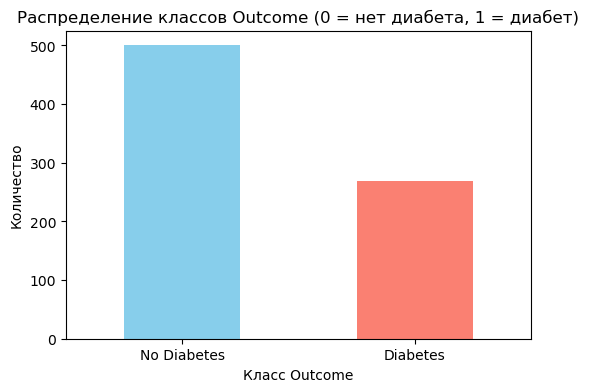

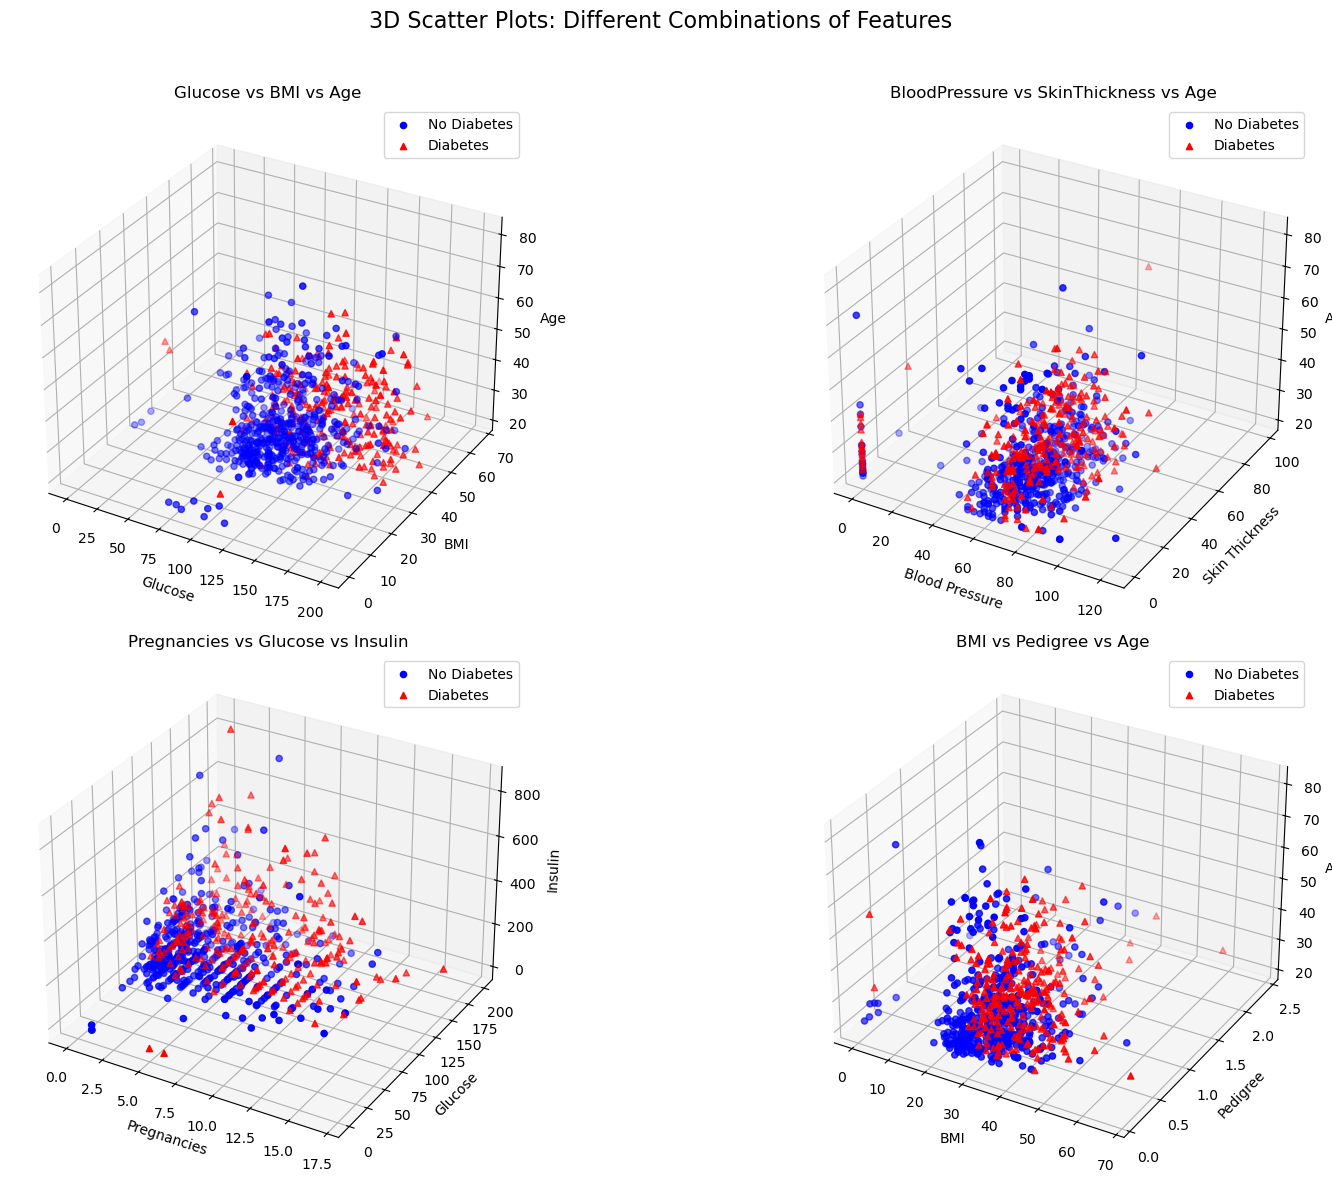

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Визуализируем распределение классов (0 - нет диабета, 1 - есть диабет)
plt.figure(figsize=(6, 4))
df['Outcome'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение классов Outcome (0 = нет диабета, 1 = диабет)')
plt.xlabel('Класс Outcome')
plt.ylabel('Количество')
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'], rotation=0)
plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Разделяем данные на два класса по Outcome
df_no_diabetes = df[df['Outcome'] == 0]  # Нет диабета
df_diabetes = df[df['Outcome'] == 1]     # Есть диабет

# Создаем несколько 3D Scatter Plot с разными комбинациями признаков
fig = plt.figure(figsize=(18, 12))

# 1. Glucose, BMI, Age
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(df_no_diabetes['Glucose'], df_no_diabetes['BMI'], df_no_diabetes['Age'], 
            c='blue', marker='o', label='No Diabetes')
ax1.scatter(df_diabetes['Glucose'], df_diabetes['BMI'], df_diabetes['Age'], 
            c='red', marker='^', label='Diabetes')
ax1.set_xlabel('Glucose')
ax1.set_ylabel('BMI')
ax1.set_zlabel('Age')
ax1.set_title('Glucose vs BMI vs Age')
ax1.legend()

# 2. BloodPressure, SkinThickness, Age
ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(df_no_diabetes['BloodPressure'], df_no_diabetes['SkinThickness'], df_no_diabetes['Age'], 
            c='blue', marker='o', label='No Diabetes')
ax2.scatter(df_diabetes['BloodPressure'], df_diabetes['SkinThickness'], df_diabetes['Age'], 
            c='red', marker='^', label='Diabetes')
ax2.set_xlabel('Blood Pressure')
ax2.set_ylabel('Skin Thickness')
ax2.set_zlabel('Age')
ax2.set_title('BloodPressure vs SkinThickness vs Age')
ax2.legend()

# 3. Pregnancies, Glucose, Insulin
ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(df_no_diabetes['Pregnancies'], df_no_diabetes['Glucose'], df_no_diabetes['Insulin'], 
            c='blue', marker='o', label='No Diabetes')
ax3.scatter(df_diabetes['Pregnancies'], df_diabetes['Glucose'], df_diabetes['Insulin'], 
            c='red', marker='^', label='Diabetes')
ax3.set_xlabel('Pregnancies')
ax3.set_ylabel('Glucose')
ax3.set_zlabel('Insulin')
ax3.set_title('Pregnancies vs Glucose vs Insulin')
ax3.legend()

# 4. BMI, Pedigree, Age
ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(df_no_diabetes['BMI'], df_no_diabetes['Pedigree'], df_no_diabetes['Age'], 
            c='blue', marker='o', label='No Diabetes')
ax4.scatter(df_diabetes['BMI'], df_diabetes['Pedigree'], df_diabetes['Age'], 
            c='red', marker='^', label='Diabetes')
ax4.set_xlabel('BMI')
ax4.set_ylabel('Pedigree')
ax4.set_zlabel('Age')
ax4.set_title('BMI vs Pedigree vs Age')
ax4.legend()

# Настройки и отображение графиков
plt.suptitle('3D Scatter Plots: Different Combinations of Features', size=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()



## Реализация метода k-ближайших соседей (k-NN)

### Теория метода k-NN
Метод **k-ближайших соседей (k-Nearest Neighbors, k-NN)** — это простой и эффективный алгоритм для задач классификации и регрессии. Основная идея заключается в том, чтобы для нового примера найти **k ближайших соседей** в обучающей выборке и присвоить метку класса на основе большинства среди этих соседей.

#### Основные шаги алгоритма:
1. **Вычислить расстояние** между новым примером и всеми точками обучающей выборки. Обычно используется **евклидово расстояние**:
   $$
   d(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
   $$
   где \( x \) и \( y \) — это два примера с \( n \)-мерными признаками.

2. **Отсортировать** всех соседей по расстоянию и выбрать \( k \) ближайших.

3. **Проголосовать за класс**: присвоить новый пример к классу, который наиболее часто встречается среди \( k \) ближайших соседей.

In [26]:
import numpy as np
import pandas as pd
from collections import Counter

# Функция для вычисления евклидова расстояния
def euclidean_distance(row1, row2):
    return np.sqrt(np.sum((row1 - row2) ** 2))

# Функция для реализации k-NN
def k_nearest_neighbors(X_train, y_train, X_test, k=3):
    y_pred = []  # Предсказанные классы для тестовой выборки

    for test_point in X_test:
        # Вычисляем расстояния от тестовой точки до всех обучающих точек
        distances = np.array([euclidean_distance(test_point, x) for x in X_train])
        
        # Находим индексы k ближайших соседей
        k_indices = distances.argsort()[:k]
        
        # Определяем классы этих соседей
        k_nearest_labels = y_train[k_indices]
        
        # Проголосуем за самый частый класс среди соседей
        most_common = Counter(k_nearest_labels).most_common(1)
        y_pred.append(most_common[0][0])  # Класс с наибольшим числом голосов

    return np.array(y_pred)


def train_test_split_manual(X, y, test_size=0.2, random_state=None):
    np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    test_size = int(len(X) * test_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test


def confusion_matrix_manual(y_true, y_pred):
    unique_classes = np.unique(y_true)
    matrix = np.zeros((len(unique_classes), len(unique_classes)), dtype=int)
    
    for true, pred in zip(y_true, y_pred):
        matrix[true, pred] += 1
    
    return matrix

# Разделим данные на тренировочную и тестовую выборки
X = df.drop(columns=['Outcome']).values
y = df['Outcome'].values

# Ручное разделение на тренировочные и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split_manual(X, y, test_size=0.2, random_state=42)

# Модель 1: Случайные признаки
random_columns = np.random.choice(X.shape[1], size=3, replace=False)
X_train_random = X_train[:, random_columns]
X_test_random = X_test[:, random_columns]

# Модель 2: Фиксированный набор признаков
fixed_columns = [1, 5, 7]  # Indices for Glucose, BMI, Age
X_train_fixed = X_train[:, fixed_columns]
X_test_fixed = X_test[:, fixed_columns]

k_values = [3, 5, 10]
# Для каждой модели вычисляем результаты при разных k и строим матрицу ошибок
for k in k_values:
    print(f"=== k = {k} ===")
    
    # Модель 1
    y_pred_random = k_nearest_neighbors(X_train_random, y_train, X_test_random, k)
    cm_random = confusion_matrix_manual(y_test, y_pred_random)
    print(f"Матрица ошибок для случайных признаков (k={k}):\n{cm_random}")
    
    # Модель 2
    y_pred_fixed = k_nearest_neighbors(X_train_fixed, y_train, X_test_fixed, k)
    cm_fixed = confusion_matrix_manual(y_test, y_pred_fixed)
    print(f"Матрица ошибок для фиксированных признаков (k={k}):\n{cm_fixed}")

=== k = 3 ===
Матрица ошибок для случайных признаков (k=3):
[[78 20]
 [25 30]]
Матрица ошибок для фиксированных признаков (k=3):
[[77 21]
 [19 36]]
=== k = 5 ===
Матрица ошибок для случайных признаков (k=5):
[[80 18]
 [28 27]]
Матрица ошибок для фиксированных признаков (k=5):
[[76 22]
 [18 37]]
=== k = 10 ===
Матрица ошибок для случайных признаков (k=10):
[[82 16]
 [26 29]]
Матрица ошибок для фиксированных признаков (k=10):
[[79 19]
 [20 35]]


In [6]:
import numpy as np

# Разделим данные на признаки (X) и целевую переменную (y)
X = df.drop('Performance Index', axis=1).values
y = df['Performance Index'].values

# Определим размер обучающей выборки (80% от общего количества данных)
train_size = int(0.8 * len(X))

# Перемешаем индексы для случайного разделения
indices = np.random.permutation(len(X))

# Разделим данные на обучающую и тестовую выборки
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Проверим размеры полученных наборов
print(f'Размер обучающей выборки: {X_train.shape}')
print(f'Размер тестовой выборки: {X_test.shape}')

Размер обучающей выборки: (8000, 5)
Размер тестовой выборки: (2000, 5)


### Небольшое пояснение

Чё ваще мы делаем?  
|> мы хотим предсказать по признакам X, какая будет целевая переменная Y  
|> поэтому, мы делим столбцы на X и Y  

Зачем делить выборку на *тестовую* и *обучающую*?  
|> так работает МО:  
|> обучающая выборка - данные, на которых обучается модель (анализ зависимостей между признаками (input) и целевой переменной (output), настройка своих коэффициентов)  
|> тестовая выборка - данные, которые **не использовались** при обучении. Нужны чтоб проверить как модель будет предсказывать значения на новых данных.  